In [20]:
import ipaddress
import random

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Interaction

In [2]:
mirai_df = pd.read_pickle("../data/blog_eda/mirai.pkl")
benign_df = pd.read_pickle("../data/blog_eda/benign.pkl")

In [3]:
mirai_df.columns

Index(['Timestamp', 'Source IP', 'Destination IP', 'Source Port',
       'Destination Port', 'Payload', 'Packet Length', 'Protocol'],
      dtype='object')

In [4]:
mirai_df = mirai_df.dropna(
    subset=["Source IP", "Destination IP", "Source Port", "Destination Port"]
)

In [5]:
benign_df = benign_df.dropna(
    subset=["Source IP", "Destination IP", "Source Port", "Destination Port"]
)

In [6]:
def incoming_outgoing_traffic(df):
    # Create incoming and outgoing traffic columns for each local IP
    local_ips = df["Source IP"].unique()
    traffic_data = {'IP': local_ips, 'incoming_traffic': [], 'outgoing_traffic': []}

    for ip in local_ips:
        incoming_traffic_condition = df["Destination IP"] == ip
        outgoing_traffic_condition = (df["Source IP"] == ip) & (
            ~df["Destination IP"].str.startswith("192.168.") & (
            ~df["Destination IP"].str.startswith("10."))
        )

        incoming_traffic_count = df[incoming_traffic_condition].shape[0]
        outgoing_traffic_count = df[outgoing_traffic_condition].shape[0]

        traffic_data['incoming_traffic'].append(incoming_traffic_count)
        traffic_data['outgoing_traffic'].append(outgoing_traffic_count)

    # Create a new DataFrame
    traffic_df = pd.DataFrame(traffic_data)
    traffic_df.set_index('IP', inplace=True)

    return traffic_df

In [7]:
mirai_traffic_df = incoming_outgoing_traffic(mirai_df)

In [8]:
benign_traffic_df = incoming_outgoing_traffic(benign_df)

In [9]:
mirai_traffic_df.head()

,incoming_traffic,outgoing_traffic
IP,,
192.168.2.108,0,51747
192.168.2.115,4257,714
192.168.2.1,27647,400
192.168.2.112,0,7787
192.168.2.110,8205,4884


In [10]:
# Create an interaction feature: incoming to outgoing traffic ratio
mirai_traffic_df["traffic_ratio"] = (
    mirai_traffic_df["incoming_traffic"] / mirai_traffic_df["outgoing_traffic"]
)

# Display the updated DataFrame
mirai_traffic_df.head()

,incoming_traffic,outgoing_traffic,traffic_ratio
IP,,,
192.168.2.108,0,51747,0.000000
192.168.2.115,4257,714,5.962185
192.168.2.1,27647,400,69.117500
192.168.2.112,0,7787,0.000000
192.168.2.110,8205,4884,1.679975


In [13]:
benign_traffic_df["traffic_ratio"] = (
    benign_traffic_df["incoming_traffic"] / benign_traffic_df["outgoing_traffic"]
)

# Display the updated DataFrame
benign_traffic_df.head()

,incoming_traffic,outgoing_traffic,traffic_ratio
IP,,,
10.0.0.1,0,144,0.0
10.0.0.2,0,146,0.0
10.200.200.101,40,0,inf
10.200.200.102,36,0,inf
10.200.200.201,0,0,NaN


/home/drx/sandbox/cyber-ml/.venv/lib/python3.10/site-packages/numpy/lib/function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/home/drx/sandbox/cyber-ml/.venv/lib/python3.10/site-packages/numpy/lib/function_base.py:4529: RuntimeWarning: invalid value encountered in multiply
  lerp_interpolation = asanyarray(add(a, diff_b_a * t, out=out))


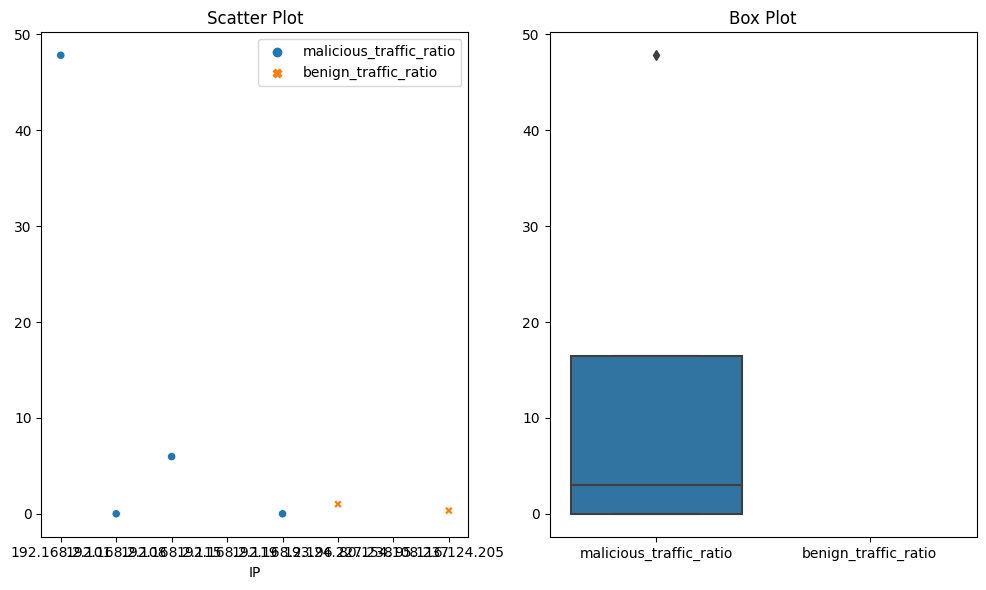

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Random sample data from malicious and benign
data = {
    "malicious_traffic_ratio": mirai_traffic_df["traffic_ratio"].sample(n = 5, random_state = 42),
    "benign_traffic_ratio": benign_traffic_df["traffic_ratio"].sample(n = 5, random_state = 42),
}

df = pd.DataFrame(data)

# Plotting using matplotlib and seaborn
plt.figure(figsize=(10, 6))

# Scatter plot
plt.subplot(1, 2, 1)
sns.scatterplot(data=df)
plt.title("Scatter Plot")

# Box plot
plt.subplot(1, 2, 2)
sns.boxplot(data=df)
plt.title("Box Plot")

# Show the plots
plt.tight_layout()
plt.show()

# Cumulative

In [21]:
# create a cumulative sum of packet lengths per source IP
mirai_df['cumulative_length'] = mirai_df.groupby('Source IP')['Packet Length'].cumsum()

In [22]:
mirai_df.head()

,Timestamp,Source IP,Destination IP,Source Port,Destination Port,Payload,Packet Length,Protocol,cumulative_length
0,1540446382.933899,192.168.2.108,52.24.43.67,21074.0,80.0,Padding,26,6.0,26
1,1540446382.933904,192.168.2.108,52.25.66.250,20532.0,8280.0,Padding,26,6.0,52
7,1540446383.391651,192.168.2.115,192.168.2.1,2440.0,53.0,"DNS Qry ""b'xmpp.samsungsmartcam.com.Speedport_...",83,17.0,83
8,1540446383.393709,192.168.2.1,192.168.2.115,53.0,2440.0,DNS Ans,83,17.0,83
9,1540446383.435821,192.168.2.108,52.24.43.67,21074.0,80.0,Padding,26,6.0,78


In [23]:
# create a cumulative sum of packet lengths per source IP
benign_df["cumulative_length"] = benign_df.groupby("Source IP")["Packet Length"].cumsum()

In [24]:
benign_df.head()

,Timestamp,Source IP,Destination IP,Source Port,Destination Port,Payload,Packet Length,Protocol,cumulative_length
4,1355253962.658551,10.0.0.1,224.0.0.2,646.0,646.0,Raw,42,17.0,42
5,1355253962.658551,10.0.0.1,224.0.0.2,646.0,646.0,Raw,42,17.0,84
6,1355253962.845551,10.0.0.2,224.0.0.2,646.0,646.0,Raw,42,17.0,42
7,1355253962.845551,10.0.0.2,224.0.0.2,646.0,646.0,Raw,42,17.0,84
26,1355253966.932551,10.0.0.2,224.0.0.2,646.0,646.0,Raw,42,17.0,126


# Derivative & Log transform

In [30]:
def interarrival(df):
    columns = ["interarrival"]
    new_df = pd.DataFrame(columns=columns)
    # Calculate interarrivals
    new_df["interarrival"] = df["Timestamp"].diff()

    return new_df


mirai_interarrival = interarrival(mirai_df)

In [31]:
mirai_interarrival["log_interarrival"] = np.log1p(mirai_interarrival["interarrival"].astype(float))

In [38]:
mirai_interarrival = mirai_interarrival.drop(0)
mirai_interarrival = mirai_interarrival.reset_index(drop=True)

In [39]:
mirai_interarrival.head()

,interarrival,log_interarrival
0,0.000005,0.000005
1,0.457747,0.376892
2,0.002058,0.002056
3,0.042112,0.041249
4,0.000063,0.000063


In [34]:
import matplotlib.pyplot as plt

def plot_interarrival(df):
    # Plot the three lines
    plt.plot(df['interarrival'], label='Interarrival')
    plt.plot(df['log_interarrival'], label='Log Interarrival')

    # Add labels and legend
    plt.xlabel('Index')
    plt.ylabel('Values')
    plt.legend()

    # Show the plot
    plt.show()


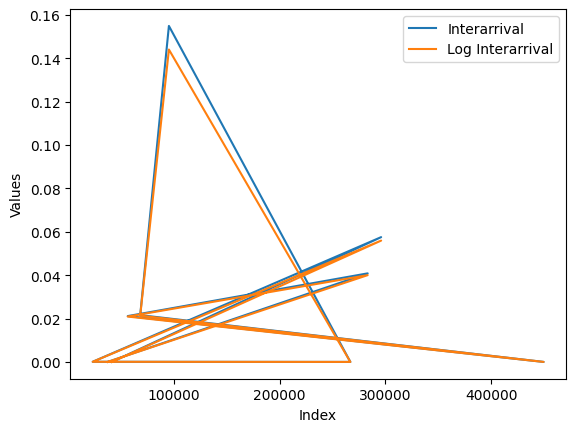

In [36]:
plot_interarrival(mirai_interarrival.sample(n=10, random_state=11))

(array([9.7613e+04, 6.4640e+03, 5.0300e+03, 4.7610e+03, 4.1000e+03,
        3.5450e+03, 3.0970e+03, 2.8160e+03, 2.4890e+03, 2.5160e+03,
        2.1750e+03, 1.7350e+03, 1.5850e+03, 1.4380e+03, 1.2600e+03,
        1.1890e+03, 1.0950e+03, 9.6400e+02, 8.9200e+02, 8.5200e+02,
        8.2300e+02, 7.0200e+02, 6.4300e+02, 5.9400e+02, 5.1900e+02,
        5.1100e+02, 4.5300e+02, 4.1500e+02, 3.8400e+02, 3.3200e+02,
        3.0300e+02, 2.7200e+02, 2.4300e+02, 2.2000e+02, 2.3500e+02,
        1.8900e+02, 1.7500e+02, 1.5000e+02, 1.5700e+02, 1.3300e+02,
        1.1100e+02, 1.1400e+02, 2.7700e+02, 5.0000e+01, 5.0000e+01,
        3.9000e+01, 4.1000e+01, 3.2000e+01, 2.2000e+01, 3.0000e+01,
        1.8000e+01, 1.9000e+01, 1.5000e+01, 1.9000e+01, 1.3000e+01,
        1.1000e+01, 1.6000e+01, 1.3000e+01, 1.3000e+01, 1.2000e+01,
        9.0000e+00, 1.7000e+01, 1.0000e+01, 5.0000e+00, 7.0000e+00,
        8.0000e+00, 3.0000e+00, 3.0000e+00, 3.0000e+00, 4.0000e+00,
        3.0000e+00, 2.0000e+00, 2.0000e+00, 4.00

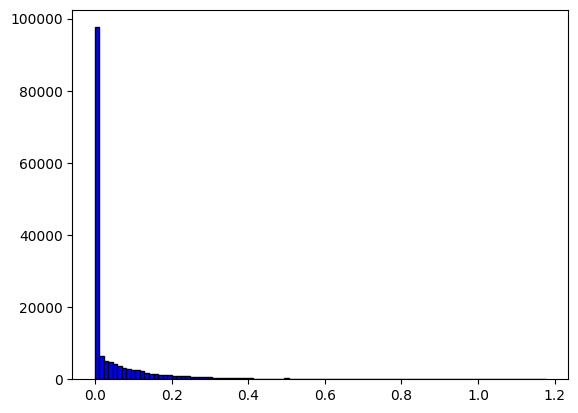

In [46]:
plt.hist(mirai_interarrival['interarrival'], bins=100, color='blue', edgecolor='black')

(array([9.3722e+04, 6.4030e+03, 3.9780e+03, 3.5260e+03, 3.1720e+03,
        3.3810e+03, 2.8900e+03, 2.6430e+03, 2.2900e+03, 2.2350e+03,
        2.0740e+03, 1.8920e+03, 1.8120e+03, 1.8900e+03, 1.7420e+03,
        1.4560e+03, 1.2570e+03, 1.2410e+03, 1.0900e+03, 1.0800e+03,
        9.4900e+02, 9.3000e+02, 9.0400e+02, 8.0300e+02, 7.2100e+02,
        7.2400e+02, 6.8200e+02, 7.0800e+02, 6.0100e+02, 5.7000e+02,
        5.1800e+02, 5.0000e+02, 4.4500e+02, 4.3100e+02, 4.1200e+02,
        3.7800e+02, 3.5600e+02, 3.3100e+02, 2.8400e+02, 2.7800e+02,
        2.4900e+02, 2.2800e+02, 2.0400e+02, 2.0300e+02, 2.0500e+02,
        1.7200e+02, 1.4900e+02, 1.4400e+02, 1.4700e+02, 1.1200e+02,
        1.0000e+02, 1.5200e+02, 2.2900e+02, 4.2000e+01, 4.7000e+01,
        3.7000e+01, 4.4000e+01, 3.2000e+01, 2.3000e+01, 2.4000e+01,
        2.3000e+01, 1.7000e+01, 2.1000e+01, 1.5000e+01, 1.1000e+01,
        1.7000e+01, 1.4000e+01, 1.4000e+01, 1.3000e+01, 1.5000e+01,
        1.5000e+01, 7.0000e+00, 8.0000e+00, 9.00

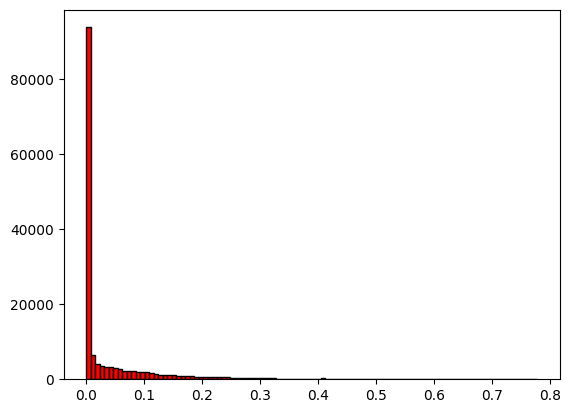

In [47]:
plt.hist(mirai_interarrival["log_interarrival"], bins=100, color="red", edgecolor="black")

# Log transformation example
Below there is a random number example that demonstrates the smoothening achieved by log transformation.

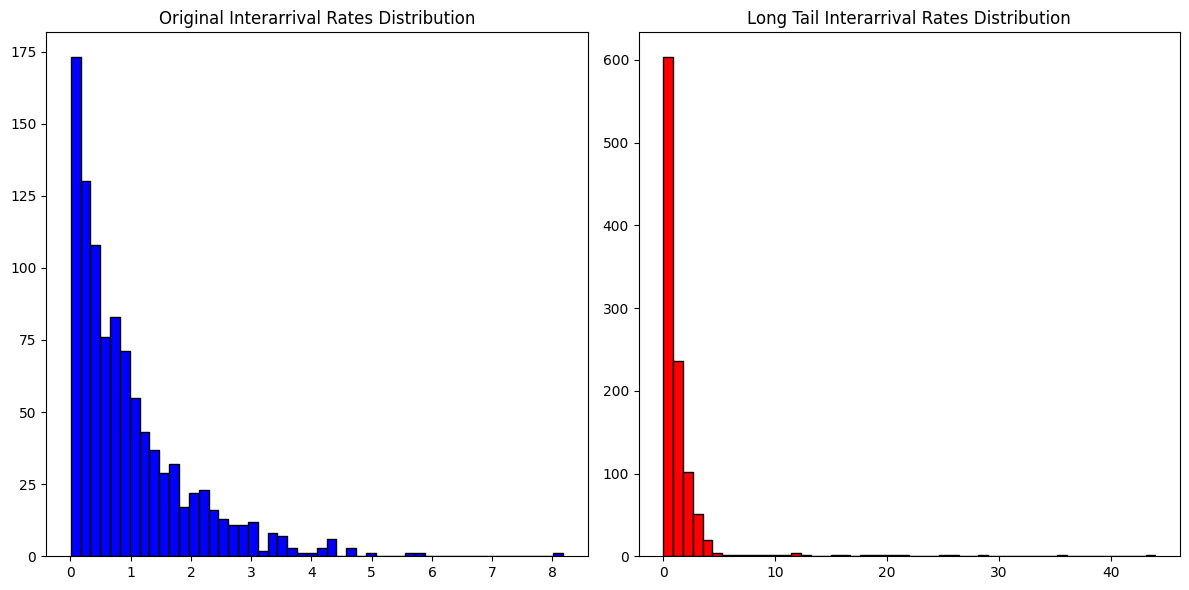

In [44]:
# Set a seed for reproducibility
np.random.seed(42)

# Generate long-tail interarrival rates
interarrival_rates = np.random.exponential(scale=1.0, size=1000)
long_tail_values = np.concatenate(
    (interarrival_rates, np.random.exponential(scale=10.0, size=50))
)

# Plot the original distribution
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(interarrival_rates, bins=50, color="blue", edgecolor="black")
plt.title("Original Interarrival Rates Distribution")

# Plot the long-tail distribution
plt.subplot(1, 2, 2)
plt.hist(long_tail_values, bins=50, color="red", edgecolor="black")
plt.title("Long Tail Interarrival Rates Distribution")

plt.tight_layout()
plt.show()

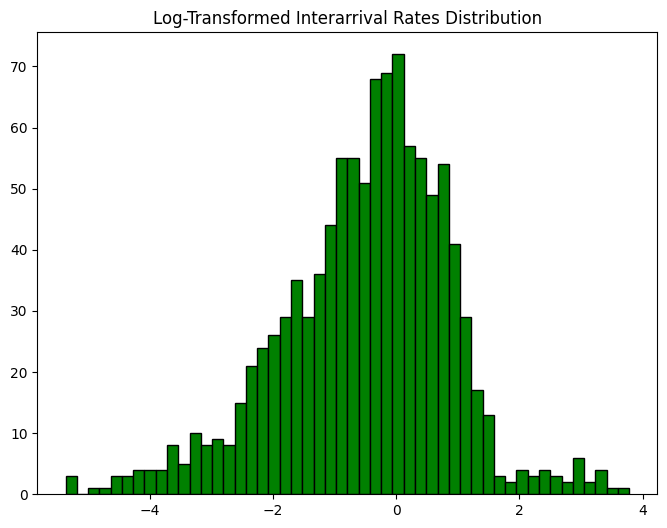

In [45]:
# Apply a log transform
log_long_tail_values = np.log(long_tail_values)

# Plot the log-transformed distribution
plt.figure(figsize=(8, 6))

plt.hist(log_long_tail_values, bins=50, color="green", edgecolor="black")
plt.title("Log-Transformed Interarrival Rates Distribution")

plt.show()

# ipaddress

In [48]:
def ip_to_numeric(ip):
    ip_obj = ipaddress.ip_interface(ip)
    return int(ip_obj.network.network_address)

In [51]:
def generate_random_ips(num_ips):
    ips = []

    # Define a list of public IP ranges and private IP ranges
    public_ranges = [ipaddress.IPv4Network('8.8.8.0/24'), ipaddress.IPv4Network('203.0.113.0/24'), ipaddress.IPv4Network('42.42.0.0/16')]
    private_ranges = [ipaddress.IPv4Network('192.168.1.0/24'), ipaddress.IPv4Network('10.0.0.0/8'), ipaddress.IPv4Network('172.16.0.0/12')]

    # Add at least two IP addresses from the same private subnet
    private_subnet = random.choice(private_ranges)
    ips.append(str(private_subnet.network_address))
    ips.append(str(private_subnet.network_address + 1))

    # Generate the remaining random IP addresses
    for _ in range(num_ips - 2):
        if random.choice([True, False]):
            # Choose a random public IP
            ip = str(random.choice(public_ranges).network_address + random.randint(0, 255))
        else:
            # Choose a random private IP
            ip = str(random.choice(private_ranges).network_address + random.randint(0, 255))

        ips.append(ip)

    return ips

# Generate a list of 100 random IPs
random_ips = generate_random_ips(10)


In [52]:
for ip in random_ips:
    print(f"{ip} -> {ip_to_numeric(ip)}")

10.0.0.0 -> 167772160
10.0.0.1 -> 167772161
42.42.0.236 -> 707395820
42.42.0.201 -> 707395785
192.168.1.177 -> 3232235953
192.168.1.108 -> 3232235884
172.16.0.178 -> 2886729906
192.168.1.49 -> 3232235825
192.168.1.77 -> 3232235853
8.8.8.197 -> 134744261
